------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.7.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
import pickle
import json

import collections
from collections import Counter
# import requests

import matplotlib.pyplot as plt
import numpy as np

# extra imports
from dataclasses import dataclass
import copy

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
if not os.path.exists('./reviews.json'):
    !wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
    # download review data
    !wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2021-11-17 16:52:54--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.05s   

2021-11-17 16:52:54 (13.9 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2021-11-17 16:52:54--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
def map_sentences(data, fn):
    result = []
    for datapoint in data:
        new_data_point = {key: value for key, value in datapoint.items()}
        new_data_point['content'] = fn(datapoint['content'])
        result.append(new_data_point)
    
    return result

def sentences_to_lower_case(sentences):
    return [[(word.lower(), pos) for word, pos in sentence] for sentence in sentences]

reviews = map_sentences(reviews, sentences_to_lower_case)

In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 10:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abash pos1=verb stemmed1=y priorpolarity=negative
type=weaksubj len=1 word1=abate pos1=verb stemmed1=y priorpolarity=negative
type=weaksubj len=1 word1=abdicate pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=aberration pos1=adj stemmed1=n priorpolarity=negative
type=strongsubj len=1 word1=aberration pos1=noun stemmed1=n priorpolarity=negative
type=strongsubj len=1 word1=abhor pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
def parse_lexicon():
  result = dict()
  with open("sent_lexicon", mode="r", encoding="utf-8") as lexicon_file:
    for line in lexicon_file:
      [type_elem, _, word, pos, _, priorpolarity] = [elem.split('=')[1] for elem in line.split(' ')]
      result[word] = (type_elem, priorpolarity[:-1])
  
  return result
    
def classify_sbinary(sentences, lexicon_dict):
    sbinary = 0
    for sentence in sentences:
        for token, pos in sentence:
            type_and_priorpolairty = lexicon_dict.get((token))
            
            # print(type_and_priorpolairty)
            
            if type_and_priorpolairty is not None:
                _, priorpolairty = type_and_priorpolairty
            
                # print(priorpolairty)
            
                if priorpolairty == "negative":
                    sbinary -= 1
                elif priorpolairty == "positive":
                    sbinary += 1

    
                    
    return sbinary >= 8

lexicon_dict = parse_lexicon()

correct = 0
total = 0
for review in reviews:
    sentiment_positive = review['sentiment'] == 'POS'
    prediction_positive = classify_sbinary(review['content'], lexicon_dict)
    
    total += 1
    if sentiment_positive == prediction_positive:
        correct += 1
        

print(correct, '/', total)
print(correct / total)  

1358 / 2000
0.679


In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.

reals = [review['sentiment'] == 'POS' for review in reviews]

token_results = [
    classify_sbinary(review['content'], lexicon_dict)
    for
    review in reviews
]
token_accuracy = sum((real == prediction for real, prediction in zip(reals, token_results))) / len(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
def classify_sweighted(sentences, lexicon_dict, weak_strength=0.2, strong_strength=1, threshold=6):
    sbinary = 0
    for sentence in sentences:
        for token, pos in sentence:
            type_and_priorpolairty = lexicon_dict.get((token))
                        
            if type_and_priorpolairty is not None:
                strength_type, priorpolairty = type_and_priorpolairty
                            
                strength = weak_strength if strength_type == 'weaksubj' else strong_strength
                            
                if priorpolairty == "negative":
                    sbinary -= strength
                elif priorpolairty == "positive":
                    sbinary += strength
    
    return sbinary >= threshold

def best_params(fn, weak_strengths, thresholds):
    reals = [review['sentiment'] == 'POS' for review in reviews]
    
    best = (None, None)
    best_accuracy = -100

    for weak_strength in weak_strengths:
        for threshold in thresholds:
            token_results = [
                fn(review['content'], lexicon_dict, weak_strength, 1, threshold)
                for
                review in reviews
            ]
            token_accuracy = sum((real == prediction for real, prediction in zip(reals, token_results))) / len(token_results)
            
            if token_accuracy > best_accuracy:
                best_accuracy = token_accuracy
                best = (weak_strength, threshold)
                
            print(token_accuracy, weak_strength, threshold)
    return best, best_accuracy

if False:
    print(best_params(classify_sweighted, [0.1, 0.15, 0.2, 0.5, 0.7], [2, 4, 6, 8, 10, 12, 14]))
    

In [ ]:
reals = [review['sentiment'] == 'POS' for review in reviews]
magnitude_results = [
    classify_sweighted(review['content'], lexicon_dict)
    for
    review in reviews
]
magnitude_accuracy = sum((real == prediction for real, prediction in zip(reals, magnitude_results))) / len(token_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.4) Make a barplot of the two results (0.5pt)

<BarContainer object of 2 artists>

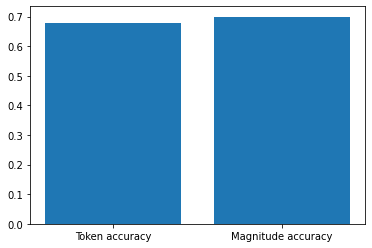

In [ ]:
plt.bar(['Token accuracy', 'Magnitude accuracy'], [token_accuracy, magnitude_accuracy])

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

The threshold of 8 is an absolute value, which can result in classification difficulties when we don't account for document length. If a review, for example, only has one sentence with 10 words, it is very hard to classify this review as positive as it needs at least 8 positive words. A review with less than 8 words will in this case never be classified as positive (even if the review says "Best movie ever. This is amazing." The other way around, if a review is very long and contains 800 words, only 1% of those words have to get a positive polarity for the review to get a positive classification (even if the other 99% is negative). In other words, the shorter the document, the harder it is to be classified as positive and the longer the document the easier it is to be classified as positive. It is therefore a problem if we don't account for document length. The length of the document must not influence the probability of the review being classified as either positive or negative.

To account for *document length*, we could use a different threshold and compare it against $\frac{s_{weighted}}{n}$ where $n$ is the number of recognised words.

In [ ]:
def classify_sweighted_better_threshold(sentences, lexicon_dict, weak_strength=0.2, strong_strength=1, threshold=6):
    sbinary = 0
    known_tokens = 0
    for sentence in sentences:
        for token, pos in sentence:
            type_and_priorpolairty = lexicon_dict.get(token)
                        
            if type_and_priorpolairty is not None:
                known_tokens += 1
                
                strength_type, priorpolairty = type_and_priorpolairty
                strength = weak_strength if strength_type == 'weaksubj' else strong_strength
                            
                if priorpolairty == "negative":
                    sbinary -= strength
                elif priorpolairty == "positive":
                    sbinary += strength
    
    return sbinary / known_tokens >= threshold

if False:
    print(best_params(classify_sweighted_better_threshold, [0.1, 0.15, 0.2, 0.3], [-0.1, 0.03, 0.04, 0.05, 0.07, 0.1, 0.3, 0.5]))


reals = [review['sentiment'] == 'POS' for review in reviews]
threshold_results = [
    classify_sweighted(review['content'], lexicon_dict)
    for
    review in reviews
]
threshold_accuracy = sum((real == prediction for real, prediction in zip(reals, threshold_results))) / len(token_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

**(Q2.1) Answer:**
Skipping the word is equivalent to adding 0. If you would add a word that is seen in only one sentiment class to the likelihood of that class the likelihood will decrease. This happend because each conditional probability for that word will be less than 1, resulting in a negative log-probability (thus, decreasing the likelihood). Consequently, the likelihood of the class the word did occur in will decrease more than the likelihood of the class the word did not occur in. This is exactly the opposite of what should happen!

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
def class_index(class_name): return 0 if class_name == 'NEG' else 1
def flat(list_of_lists): return (item for list_ in list_of_lists for item in list_)

def unique_words(data, include_pos=False):
    result = set()

    for datapoint in data:
        for sentence in datapoint['content']:
            for word, pos in sentence:
                if include_pos:
                    result.add((word, pos))
                else:
                    result.add(word)
    
    return result

@dataclass
class NaiveBayesClassifier():
    word_class_count: dict
    total_words: list
    class_count: list
        

def train_naive_bayes(data, skip_if_missing=False):
    if(skip_if_missing):
        unique_positive = unique_words((r for r in data if r['sentiment'] == 'POS'))
        unique_negative = unique_words((r for r in data if r['sentiment'] == 'NEG'))
    word_class_count = Counter()
    total_words = [0, 0]
    class_count = [0, 0]
    
    for review in data:
        sentiment = review['sentiment']
        sentiment_index = class_index(sentiment)
        class_count[sentiment_index] += 1
        
        for word, pos in flat(review['content']):
            word_lower = word
            if skip_if_missing and not (word_lower in unique_positive and word_lower in unique_negative):
                continue
            word_class_count[word_lower, sentiment_index] += 1
            total_words[sentiment_index] += 1
            
    return NaiveBayesClassifier(word_class_count, total_words, class_count)


def test_naive_bayes(data, classifier, word_probability):
    correct = 0
    total = len(data)
    
    for datapoint in data:
        log_ps = [log_p(flat(datapoint['content']), class_index, classifier, word_probability) for class_index in [0, 1]]
        
        prediction = 0 if log_ps[0] > log_ps[1] else 1
        real = class_index(datapoint['sentiment'])
        
        correct += prediction == real
        
    return correct, total


def log_p(sentence, class_idx, classifier, word_probability):
    result = 0
    
    class_count = classifier.class_count[class_idx]
    total_amount_of_sentences = sum(classifier.class_count)
    
    result += math.log2(class_count / total_amount_of_sentences)
    
    for word, pos in sentence:
        result += word_probability(classifier, word, pos, class_idx)
            
    return result
        

def probability_or_zero(classifier, word, pos, class_idx):
    count = classifier.word_class_count[word, class_idx]

    if count == 0 or classifier.word_class_count[word, 1 - class_idx] == 0:
        return 0
    else:
        return math.log2(count / classifier.total_words[class_idx])
    

def filter_review_range(min, max, reviews):
    return [r for r in reviews if min <= r['cv'] < max]

train = filter_review_range(0, 900, reviews)
test = filter_review_range(900, 1000, reviews)

def evaluate_data(train, test, word_probability, skip_if_missing=False):
    classifier = train_naive_bayes(train, skip_if_missing)
    results = test_naive_bayes(test, classifier, word_probability)

    print(results)
    print("Accuracy:", results[0] / results[1])
    
evaluate_data(train, test, probability_or_zero, True)

(167, 200)
Accuracy: 0.835


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

**(Q2.3) Answer:**
In the case that 90% of our data instances are of positive movie reviews, accuracy would not be a good way to evaluate the classifier. This is due to the fact that the data is very skewed in this case. If we would predict POS all the time, our accuracy would be 90% without making any useful predictions.

By applying this, we expect the accuracy to improve, because the classification becomes easier. The prior probability of class POS becomes very high (0.9), which will result in a bias towards predicting POS labels. These predictions would also be correct most of the time. Moreover, because the class NEG is very small and we skip words that don't occur in both of the classes, we skip many words when we make predictions. This leads to the conditional probability of the word being less representative of the actual distributions of the words in the classes.


In [ ]:
positive = [r for r in reviews if r['sentiment'] == 'POS']
negative = [r for r in reviews if r['sentiment'] == 'NEG']

train_biased = filter_review_range(0, 90, negative) + filter_review_range(0, 900, positive)
test_biased = filter_review_range(900, 910, negative) + filter_review_range(900, 1000, positive)

evaluate_data(train_biased, test_biased, probability_or_zero, True)

(98, 110)
Accuracy: 0.8909090909090909


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction

$ \frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)} $

for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
def laplace_smooth_probability(k):
    def result(classifier, word, pos, class_idx):
        return math.log2(
             (classifier.word_class_count[word, class_idx] + k)
             /
             (classifier.total_words[class_idx] + k * len(classifier.word_class_count))
        )

    return result

evaluate_data(train, test, laplace_smooth_probability(1))

(164, 200)
Accuracy: 0.82


It appears that smoothing decreases the performance accuracy of out Naive Bayes classifier from 0.835 to 0.82. 

## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
def round_robin(data, fold_count, fold_idx, is_test):
    return [
        datapoint for datapoint in data if (datapoint['cv'] % fold_count == fold_idx) == is_test
    ]

def k_fold(k, data):
    accuracies = []
    
    for fold_idx in range(k):
        test = round_robin(data, k, fold_idx, True)
        train = round_robin(data, k, fold_idx, False)
        
        classifier = train_naive_bayes(train)
        correct, total = test_naive_bayes(test, classifier, laplace_smooth_probability(1))
        
        accuracies.append(correct / total)
        
    accuracy_avg = sum(accuracies) / k
    accuracy_sds = ((accuracy - accuracy_avg) ** 2 for accuracy in accuracies)
    accuracy_sd = sum(accuracy_sds) / k
    
    return accuracy_avg, accuracy_sd

accuracy_avg, accuracy_sd = k_fold(10, reviews)

print("Accuracy:", accuracy_avg)
print("Variance:", accuracy_sd)

Accuracy: 0.8185
Variance: 0.0005602499999999987


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [ ]:
print("Variance:", accuracy_sd)

Variance: 0.0005602499999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE
stemmer = PorterStemmer()

def stem_words(data):
    stemmed_data = copy.deepcopy(data)
    
    for datapoint in stemmed_data:
        datapoint['content'] = [
            [(stemmer.stem(word), pos) for word, pos in sentence]
            for sentence in datapoint['content']
        ]

    return stemmed_data

train_stemmed = stem_words(train)
test_stemmed = stem_words(test)

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [ ]:
evaluate_data(train_stemmed, test_stemmed, laplace_smooth_probability(1))

(164, 200)
Accuracy: 0.82


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
unique_words_unstemmed = unique_words(train)
unique_words_stemmed = unique_words(train_stemmed)
        
print(len(unique_words_unstemmed)) # The number of words in the vocabulary reduces from 45348
print(len(unique_words_stemmed))   # to 32404

45348
32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
sentence_break = ['<s>', '<s>']

def augment_n_gram(data, n):
    result = copy.deepcopy(data)
    for datapoint in result:
        for sentence in datapoint['content']:
            old_sentence = sentence[:]
            if n >= 2:
                for ((word1, pos1), (word2, pos2)) in zip([['<s>', '<s>']] + old_sentence, old_sentence + [['<s>', '<s>']]):
                    sentence.append([word1 + ',' + word2, pos1 + ',' + pos2])
            if n >= 3:
                for ((word1, pos1), (word2, pos2), (word3, pos3)) in zip(
                    [sentence_break] + old_sentence + [sentence_break],
                    [sentence_break, sentence_break] + old_sentence,
                    old_sentence + [sentence_break, sentence_break],
                ):
                    sentence.append([word1 + ',' + word2 + ',' + word3, pos1 + ',' + pos2 + ',' + pos3])
            if n >= 4:
                raise NotImplemented('Only up to n=3 is implemented')
    return result
        

train_data_2_gram = augment_n_gram(train[:], 2)
test_data_2_gram = augment_n_gram(test[:], 2)

train_data_3_gram = augment_n_gram(train[:], 3)
test_data_3_gram = augment_n_gram(test[:], 3)

evaluate_data(train_data_2_gram, test_data_2_gram, laplace_smooth_probability(1))
evaluate_data(train_data_3_gram, test_data_3_gram, laplace_smooth_probability(1))

(170, 200)
Accuracy: 0.85
(174, 200)
Accuracy: 0.87


The accuracy improves for both the unigrams+bigrams and unigrams+bigrams+trigrams compared to our previous Naive Bayes classifier.


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


**(Q2.10) Answer:**
In theory, the number of features increases exponentially with the size of the n-gram. If there are $v$ words in the vocabulary, and you use an $n$-gram, there are $v^n$ possible $n$-grams. However, in practice not all of these combinations actually occur in the train data because not all combinations of words are possible, and the data is usually limited. Therefore, you would not need to store all of them.

In [ ]:
words_2_gram = len(unique_words(train_data_2_gram))
words_3_gram = len(unique_words(train_data_3_gram))

print(len(unique_words(train)))
print(words_2_gram)
print(words_3_gram)

45348
470258
1390260


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
def token_ids(data, include_pos=False):
    result = collections.defaultdict(lambda: 0)

    tokens = unique_words(data, include_pos)

    for i, token in enumerate(tokens):
        result[token] = i + 1

    return result

def to_svm_features(data, token_ids, include_pos=False):
    input_size = len(token_ids) + 1

    inputs = []
    outputs = []

    for datapoint in data:
        input = [0] * input_size
        for sentence in datapoint['content']:
            for token, pos in sentence:

                if include_pos:
                    idx = token, pos
                else:
                    idx = token
                input[token_ids[idx]] += 1
        output = class_index(datapoint['sentiment'])

        inputs.append(input)
        outputs.append(output)
    
    return inputs, outputs

def print_progress(iter, max_iter):
    print("\r[" + "=" * iter + " " * (max_iter - iter) + "]", iter, "/", max_iter, end='')


def k_fold_svm(k, data, include_pos=False):
    accuracies = []
    
    for fold_idx in range(k):
        print_progress(fold_idx, k)

        test = round_robin(data, k, fold_idx, True)
        train = round_robin(data, k, fold_idx, False)

        svm_token_ids = token_ids(train, include_pos)
        svm_train_x, svm_train_y = to_svm_features(train, svm_token_ids, include_pos)

        svm = sk.svm.LinearSVC(max_iter=10000)
        svm.fit(svm_train_x, svm_train_y)

        svm_test_x, svm_test_y = to_svm_features(test, svm_token_ids, include_pos)
        
        accuracies.append(svm.score(svm_test_x, svm_test_y))

    print_progress(k, k)
    print()
        
    accuracy_avg = sum(accuracies) / k
    accuracy_sds = ((accuracy - accuracy_avg) ** 2 for accuracy in accuracies)
    accuracy_sd = sum(accuracy_sds) / k
    
    return accuracy_avg, accuracy_sd

acc, sd = k_fold_svm(10, reviews)

print('Accuracy =', acc)
print('Standard deviation of accuracy =', sd)

[==========] 10 / 10
Accuracy = 0.8320000000000001
Standard deviation of accuracy = 0.0005959999999999991


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
acc, sd = k_fold_svm(10, reviews, True)

print('Accuracy =', acc)
print('Standard deviation of accuracy =', sd)

[=======   ] 7 / 10

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[==========] 10 / 10
Accuracy = 0.8380000000000001
Standard deviation of accuracy = 0.00037099999999999975


**(Q3.1) Answer:**
Adding parts of speech information barely helped. This might be because the POS tag does not influence whether a word is positive or negative.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
def filter_pos_sentences(sentences):
    keep_pos = ['NN', 'VB', 'JJ', 'RB']
    return [
        [(word, pos) for word, pos in sentence if pos[:2] in keep_pos]
        for sentence in sentences
    ]

def filter_pos(data):
    return map_sentences(data, filter_pos_sentences)

filter_pos_data = filter_pos(reviews)


acc, sd = k_fold_svm(10, filter_pos_data, True)

print('Accuracy =', acc)
print('Standard deviation of accuracy =', sd)



[==========] 10 / 10
Accuracy = 0.849
Standard deviation of accuracy = 0.00035900000000000065


**(Q3.2) Answer:**
The accuracy increased when removing all closed-class words. An explanation is that many closed-class words don't influence whether the review is positive or negative, and that removing these reduces overfitting.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


In this movie review sentiment analysis, we have performed three major analyses: a lexicon-based approach, Naïve Bayes (NB) classification and Support Vector Machines (SVM). We can immediately conclude that the NB and SVM both outperform the lexicon-based approach, that “only” has a maximum accuracy of 0.70 when taking the magnitude of sentiment into account.

The results indicate that the NB and SVM models perform approximately equally well for the sentiment analysis, with accuracies of 0.835 and 0.832 respectively. Both methods use bag-of-words (BoW) features, which have its semantical limitations regarding sentence structure. However, our results indicate that none of the proposed techniques to overcome this limitation showed very high improvements of accuracy.

In the NB model, we first applied stemming to make the algorithm more robust. After stemming, our classifier performed with an accuracy of 0.82. Stemming reduces different forms of a word to a common base form. With this, stemming results in a relatively small reduction in feature-space, but does not gain us any meaningful information about the sentiment of the stemmed word. This might be a reason why the classifier accuracy does not improve after stemming, but even worsens a little bit. Secondly, we applied N-grams to our NB model with Laplace smoothing. N-grams features attempts to retrain word order information of the BoW. This did improve our accuracy to 0.85 for 2-grams and 0.87 for 3-grams, but also increased the feature-space substantially.

For the SVMs we applied POS disambiguation, which identifies words with their Part of Speech (POS) tags. The intuition here was that POS-tags possibly carry information about the sentiment of the word. However, as our accuracy barely improved, we can conclude that the POS-tags do not carry any sentiment information of the words. Afterwards, we discarded all closed-class words from the data, which did result in an increase of accuracy. Similar to stemming, this technique reduces the feature-space, which could explain part of the increase in accuracy. However, as mentioned in Q3.2, closed-class words do not influence the final predictions of sentiment of the reviews, so most sentiment information can still be acquired from the nouns, adjectives, and adverbs. 

Overall, we can conclude that primarily the words themselves capture meaningful sentiment information. For example, the word “amazing” would in most cases imply a positive sentiment. The attempts to improve accuracy by adding sentence structure thus barely improved the model accuracy.


# Submission 


In [ ]:
# Write your names and student numbers here:
# Student 1 Jesse Maas #113932284
# Student 2 Lizzy Da Rocha Bazilio #11426594

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 